# Segunda entrega

En esta segunda entrega vamos a hacer un análisis de reviews en Yelp.

Dado el dataset reviews.csv subido al Trello del curso, deberán hacer un análisis de las reviews.

El análisis no tiene limites y pueden agregar todas las ideas que les surjan, pero como mínimo debe incluir: keywords y tópicos por negocio (business id), sentimiento de cada review, entidades por review, negocio con más comentarios positivos y negocio con más comentarios negativos.

Además, pueden agregar por ejemplo (Opcional): Tópicos asociados sentimientos, keywords asociadas a sentimientos, sentimientos a lo largo del tiempo (utilizando la columna date)...

### Entrega

**Fecha limite**: 10 de Diciembre 2023.

Deben compartir el notebook con todo el análisis realizado por mail a hugofolonier@gmail.com.


### Presentación

**Fecha**: 9 de Enero 2024 (o la fecha correspondiente a la Clase 39).

La presentación **NO debe ser una presentación del notebook**. La presentación debe constar de filminas que muestren los **resultados** que obtuvieron, mencionar herramientas que utiliaron, que decisiones tomaron y conclusiones. No deben mostrar nada de código en la presentación.

Una vez que ya hayan presentado (por ejemplo un powerpoint), podemos resolver las dudas que surjan sobre código, etc.



---



**ÍCARO - DATA SCIENCE 0423** | **ENTREGABLE 2 - NPL**

**Integrantes Grupo 7:** Brown, Ignacio - Fedele, Delicia - Santos, Martín



---



**SECCIÓN 1:** BIBLIOTECAS Y LIBRERÍAS



In [ ]:
!pip install nltk

In [ ]:
!pip install textblob

In [ ]:
!pip install seaborn

In [ ]:
!pip install spacy
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 461.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=7a9619d7cf95441fefdc05118620701a72f7ac497acdb000f30ec16141a3ef4d
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import numpy as np

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from textblob import TextBlob
from afinn import Afinn
from collections import Counter
from nltk import ngrams
from nltk import bigrams
from nltk.probability import FreqDist
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from transformers import pipeline

**SECCIÓN 2:** EXTRACCIÓN Y EXPLORACIÓN DE DATOS

In [ ]:
#Se carga el dataset, se explora la información de las columnas y el tipo de datos que contiene y se visualiza.

In [ ]:
rev = pd.read_csv('reviews.csv')

In [ ]:
rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27290 entries, 0 to 27289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       27290 non-null  object
 1   review_id     27290 non-null  object
 2   text          27290 non-null  object
 3   votes.cool    27290 non-null  int64 
 4   business_id   27290 non-null  object
 5   votes.funny   27290 non-null  int64 
 6   stars         27290 non-null  int64 
 7   date          27290 non-null  object
 8   type          27290 non-null  object
 9   votes.useful  27290 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.1+ MB


In [ ]:
rev.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,review,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,review,0
2,auESFwWvW42h6alXgFxAXQ,fFSoGV46Yxuwbr3fHNuZig,Yes this place is a little out dated and not o...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2015-10-31,review,0
3,uK8tzraOp4M5u3uYrqIBXg,Di3exaUCFNw1V4kSNW5pgA,All the food is great here. But the best thing...,0,UsFtqoBl7naz8AVUBZMjQQ,0,5,2013-11-08,review,0
4,I_47G-R2_egp7ME5u_ltew,0Lua2-PbqEQMjD9r89-asw,We checked this place out this past Monday for...,0,UsFtqoBl7naz8AVUBZMjQQ,0,3,2014-03-29,review,0


In [ ]:
rev.describe()

,votes.cool,votes.funny,stars,votes.useful
count,27290.000000,27290.000000,27290.000000,27290.000000
mean,0.392158,0.319531,3.623232,0.830158
std,1.259318,1.122261,1.320829,1.611410
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.000000,1.000000
max,61.000000,52.000000,5.000000,52.000000


In [ ]:
#Como parte de la exploración, se intenta visualizar de manera gráfica si hay alguna tendencia o patrón entre la cantidad de reviews y el promedio de
#ratings a lo largo de los años, es decir el número de gente que opina, si tiene que ver con el tipo de opinión que emite, si es negativa o positiva.

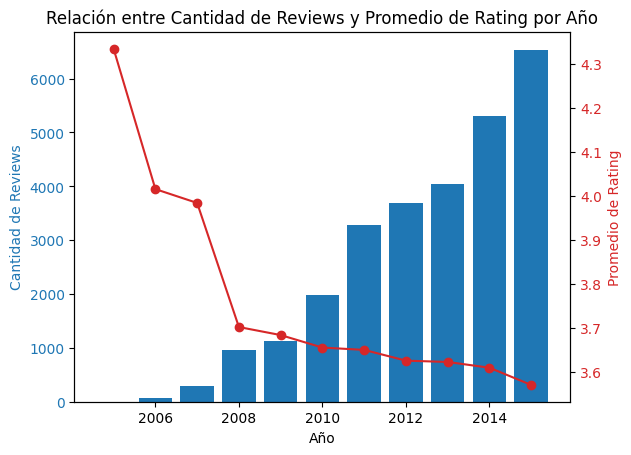

In [ ]:
rev['date'] = pd.to_datetime(rev['date'])

rev['year'] = rev['date'].dt.year

avg_rating_by_year = rev.groupby('year')['stars'].mean()

reviews_count_by_year = rev.groupby('year').size()

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Año')
ax1.set_ylabel('Cantidad de Reviews', color=color)
ax1.bar(reviews_count_by_year.index, reviews_count_by_year, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Promedio de Rating', color=color)
ax2.plot(avg_rating_by_year.index, avg_rating_by_year, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Relación entre Cantidad de Reviews y Promedio de Rating por Año')
plt.show()

In [ ]:
#Para destacar un análisis breve a simple vista es que el promedio de puntuación tiene una relación inversamente proporcional con la cantidad, si se
#quisiera pensar que esta cantidad depende de que "la gente opina menos si las opiniones son positivas" y que "la gente opina más si las opiniones
#son negativas". Concretamente las mejores puntuaciones de 4 a 5, se dieron mayormente antes del año 2007, mientras que de 1 a 4 del 2008 en adelante.

**SECCIÓN 3:** PROCESAMIENTO DE DATOS

**1) Tokenización, Stopwords y Stemming**

In [ ]:
#Se descarga los recursos de nltk y definimos funciones para tokenizar en palabras y frases, luego la aplico en la columna 'text' y visualizo.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def tokenize_words(text):
    return word_tokenize(text)

def tokenize_sentences(text):
    return sent_tokenize(text)

In [ ]:
rev['tokenized_words'] = rev['text'].apply(tokenize_words)
rev['tokenized_sentences'] = rev['text'].apply(tokenize_sentences)

In [ ]:
print("Ejemplo de tokenización de palabras:")
rev['tokenized_words'].head()

Ejemplo de tokenización de palabras:


0    [Mr, Hoagie, is, an, institution, ., Walking, ...
1    [Excellent, food, ., Superb, customer, service...
2    [Yes, this, place, is, a, little, out, dated, ...
3    [All, the, food, is, great, here, ., But, the,...
4    [We, checked, this, place, out, this, past, Mo...
Name: tokenized_words, dtype: object

In [ ]:
print("\nEjemplo de tokenización de frases:")
rev['tokenized_sentences'].head()


Ejemplo de tokenización de frases:


0    [Mr Hoagie is an institution., Walking in, it ...
1    [Excellent food., Superb customer service., I ...
2    [Yes this place is a little out dated and not ...
3    [All the food is great here., But the best thi...
4    [We checked this place out this past Monday fo...
Name: tokenized_sentences, dtype: object

In [ ]:
#Se elimina palabras comunes que no aportan información, haciendo el stopwords. Se descarga los recursos de nltk.

In [ ]:
#Este proceso nos ayuda a reducir el ruido en los datos al eliminar palabras comunes que generalmente no contribuyen a la interpretación del contenido.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return ' '.join(filtered_words)

In [ ]:
rev['text_without_stopwords'] = rev['text'].apply(remove_stopwords)

In [ ]:
print("Ejemplo de texto original:")
rev['text'].iloc[0]

Ejemplo de texto original:


'Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.'

In [ ]:
print("\nEjemplo de texto sin stopwords:")
rev['text_without_stopwords'].iloc[0]


Ejemplo de texto sin stopwords:


'mr hoagie institution walking seem like throwback years ago old fashioned menu board booths large selection food speciality italian hoagie voted best area year year usually order burger patties obviously cooked frozen ingredients fresh overall good alternative subway road'

In [ ]:
#Se opta también por hacer el stemming para reducir las palabras a su forma raíz, lo que nos ayuda a simplificar el análisis de texto y agrupar
#palabras similares.

In [ ]:
stemmer = PorterStemmer()

In [ ]:
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word.lower()) for word in words if word.isalpha()]
    return ' '.join(stemmed_words)

In [ ]:
rev['stemmed_text'] = rev['text'].apply(stem_text)

In [ ]:
print("Ejemplo de texto original:")
rev['text'].iloc[0]

Ejemplo de texto original:


'Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.'

In [ ]:
print("\nEjemplo de texto con stemming:")
rev['stemmed_text'].iloc[0]


Ejemplo de texto con stemming:


'mr hoagi is an institut walk in it doe seem like a throwback to year ago old fashion menu board booth out of the and a larg select of food their special is the italian hoagi and it is vote the best in the area year after year i usual order the burger while the patti are obvious cook from frozen all of the other ingredi are veri fresh overal it a good altern to subway which is down the road'

In [ ]:
#Hay otra forma, que es la lematización que ayuda a reducir las palabras a su forma base, lo que puede ser beneficioso para el análisis de texto al agrupar
#palabras relacionadas.

In [ ]:
#En caso que no se opte por el stemming, se deja el código para hacerlo por lematización.

In [ ]:
#lemmatizer = WordNetLemmatizer()

In [ ]:
#def lemmatize_text(text):
    #words = word_tokenize(text)
    #lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha()]
    #return ' '.join(lemmatized_words)

In [ ]:
#rev['lemmatized_text'] = rev['text'].apply(lemmatize_text)

In [ ]:
#print("Ejemplo de texto original:")
#rev['text'].iloc[0]

In [ ]:
#print("\nEjemplo de texto lematizado:")
#rev['lemmatized_text'].iloc[0]

**2) Correlación entre Sentimiento y Rating**

In [ ]:
#Se determina el sentimiento de cada review en base a la correlación que surge con el rating seleccionado.

In [ ]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [ ]:
rev['sentiment'] = rev['text'].apply(get_sentiment)

In [ ]:
print("Ejemplo de sentimiento calculado:")
rev[['text', 'sentiment', 'stars']].head()

Ejemplo de sentimiento calculado:


,text,sentiment,stars
0,"Mr Hoagie is an institution. Walking in, it do...",0.170339,4
1,Excellent food. Superb customer service. I mis...,0.933333,5
2,Yes this place is a little out dated and not o...,0.255093,5
3,All the food is great here. But the best thing...,0.569643,5
4,We checked this place out this past Monday for...,0.082843,3


In [ ]:
correlation = rev['sentiment'].corr(rev['stars'])
print("\nCorrelación entre Sentimiento y Rating:", correlation)


Correlación entre Sentimiento y Rating: 0.5650707581759007


In [ ]:
#Una correlación de 0.565 entre el sentimiento y el rating sugiere una relación positiva moderada entre estas dos variables en tu conjunto de datos.
#Es decir, cuando las reviews son más positivas, es más probable que el cliente otorgue un rating más alto. Ahora, ese valor indica que la fuerza de
#la relación no es extremadamente fuerte, pero tampoco es insignificante. Hay una tendencia, pero no todos los ratings están completamente determinados
#por el sentimiento, y puede haber otras variables en juego.

In [ ]:
#Se elije un diagrama de cajas y bigotes para visualizar la correlación entre el sentimiento de la review y el puntaje otorgado por la misma.

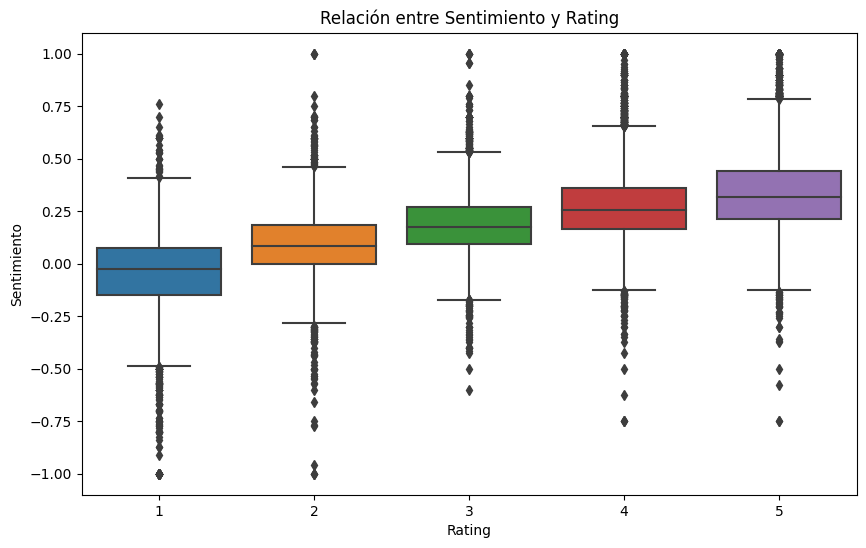

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stars', y='sentiment', data=rev, orient='v')
plt.title('Relación entre Sentimiento y Rating')
plt.xlabel('Rating')
plt.ylabel('Sentimiento')
plt.show()

In [ ]:
#La correlación no implica causalidad, por lo que no se puede afirmar que el sentimiento causa el rating ni viceversa. Puede haber otros factores que
#afectan tanto al sentimiento como al rating, y la relación podría ser bidireccional. Eso puede explicarse en parte por la gran cantidad de puntos atípicos
#que vemos. La correlación proporciona una visión general, pero no revela la naturaleza exacta de la relación.

In [ ]:
#Hasta aquí, el procesamiento fue a nivel general. Ahora se profundizará aún más cada uno de estos, pero ramificándolo para otros enfoques.

**3) Ranking de Palabras Positivas y Negativas**

In [ ]:
#El propósito es realizar un ranking de palabras que se consideran como positivas y aquellas que se consideran como negativas, pero a la vez viendo cuáles
#aparece con mayor ocurrencia, para eso se usa el Diccionario Afinn.

In [ ]:
#Visualizamos esto en un gráfico de barras horizontales donde las palabras negativas van de 0 hacia menos infinito y las palabras positivas vayan de 0 a más
#infinito, figurativamente.

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def extract_words(text):
    doc = nlp(text)
    words = [token.text.lower() for token in doc if token.is_alpha]
    return words

In [ ]:
def clean_entity(entity):
    entity = re.sub('[^a-zA-Z\s]+', '', entity)
    return entity.strip()

In [ ]:
rev['review_words'] = rev['text'].apply(extract_words)

In [ ]:
all_review_words = [word for words in rev['review_words'] for word in words]
review_words_df = pd.DataFrame(all_review_words, columns=['Word'])

In [ ]:
afinn = Afinn()

In [ ]:
word_sentiments = review_words_df['Word'].apply(afinn.score)

In [ ]:
word_sentiments_df = pd.DataFrame({'Word': review_words_df['Word'], 'Sentiment': word_sentiments})

In [ ]:
top_negative_words = word_sentiments_df[word_sentiments_df['Sentiment'] < 0].head(15)
top_positive_words = word_sentiments_df[word_sentiments_df['Sentiment'] > 0].head(15)

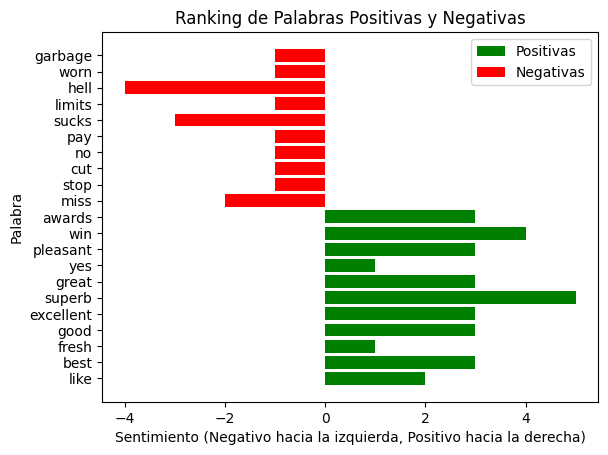

In [ ]:
plt.barh(top_positive_words['Word'], top_positive_words['Sentiment'], color='green', label='Positivas')

plt.barh(top_negative_words['Word'], top_negative_words['Sentiment'], color='red', label='Negativas')

plt.xlabel('Sentimiento (Negativo hacia la izquierda, Positivo hacia la derecha)')
plt.ylabel('Palabra')
plt.title('Ranking de Palabras Positivas y Negativas')
plt.legend()
plt.show()

In [ ]:
#Este análisis si bien puede llegar a ser útil en algunos aspectos, lo cierto es que no nos da informacion significativa, dado que por cada palabra
#no se puede determinar su asociación a un adjetivo determinado.

**4) Secuencias y Ocurrencias de Conjuntos de Palabras**

In [ ]:
#Para acercarnos a la idea de que es lo que los que reseñan valoran, se puede tomar un conjunto de 2 o 3 palabras, de esa forma pudiendo conseguir una
#mejor visualización de las opiniones mas frecuentes éstos. Para el caso se elije 3 palabras.

In [ ]:
#Se utiliza para esta secuencia, N-Grams, en vez de Tri-Grams, por el simple hecho de tener la posibilidad de manejar cualquier otro tamaño de secuencias
#y mantener la flexibilidad del código para ajustar el valor de n según sea necesario.

In [ ]:
reviews_text = rev['text']

In [ ]:
n_value = 3

In [ ]:
def get_positive_sentiment_ngrams(text, n):
    blob = TextBlob(text)
    tokens = word_tokenize(text.lower())
    ngrams_list = list(ngrams(tokens, n))
    filtered_ngrams = [
        ngram for ngram in ngrams_list
        if TextBlob(' '.join(ngram)).sentiment.polarity > 0
        and all(word not in {',', '.'} for word in ngram)  # Filtrar comas y puntos
    ]
    return filtered_ngrams

In [ ]:
def get_negative_sentiment_ngrams(text, n):
    blob = TextBlob(text)
    tokens = word_tokenize(text.lower())
    ngrams_list = list(ngrams(tokens, n))
    filtered_ngrams = [
        ngram for ngram in ngrams_list
        if TextBlob(' '.join(ngram)).sentiment.polarity < 0
        and all(word not in {',', '.'} for word in ngram)  # Filtrar comas y puntos
    ]
    return filtered_ngrams

In [ ]:
positive_sentiment_ngrams = [ngram for review in reviews_text for ngram in get_positive_sentiment_ngrams(review, n_value)]
negative_sentiment_ngrams = [ngram for review in reviews_text for ngram in get_negative_sentiment_ngrams(review, n_value)]

In [ ]:
positive_ngram_freq = FreqDist(positive_sentiment_ngrams)
negative_ngram_freq = FreqDist(negative_sentiment_ngrams)

In [ ]:
top_positive_ngrams = positive_ngram_freq.most_common(10)
top_negative_ngrams = negative_ngram_freq.most_common(10)

In [ ]:
df_top_positive_ngrams = pd.DataFrame(top_positive_ngrams, columns=['N-gram', 'Ocurrencias'])
df_top_negative_ngrams = pd.DataFrame(top_negative_ngrams, columns=['N-gram', 'Ocurrencias'])

In [ ]:
print(f"Top 10 {n_value}-grams de Sentimientos Positivos:")
print(df_top_positive_ngrams)
print(f"\nTop 10 {n_value}-grams de Sentimientos Negativos:")
print(df_top_negative_ngrams)

Top 10 3-grams de Sentimientos Positivos:
                N-gram  Ocurrencias
0      (of, the, best)          749
1   (the, first, time)          511
2       (is, a, great)          480
3       (i, love, the)          480
4    (a, great, place)          470
5      (is, the, best)          466
6   (great, place, to)          460
7  (love, this, place)          397
8      (most, of, the)          374
9    (was, very, good)          365

Top 10 3-grams de Sentimientos Negativos:
             N-gram  Ocurrencias
0  (was, a, little)          498
1   (is, a, little)          298
2   (a, few, times)          262
3  (a, little, bit)          260
4   ('m, not, sure)          252
5   (a, long, time)          248
6   (in, the, past)          222
7    (due, to, the)          216
8  (of, the, other)          213
9     (for, a, few)          206


<Figure size 1000x600 with 0 Axes>

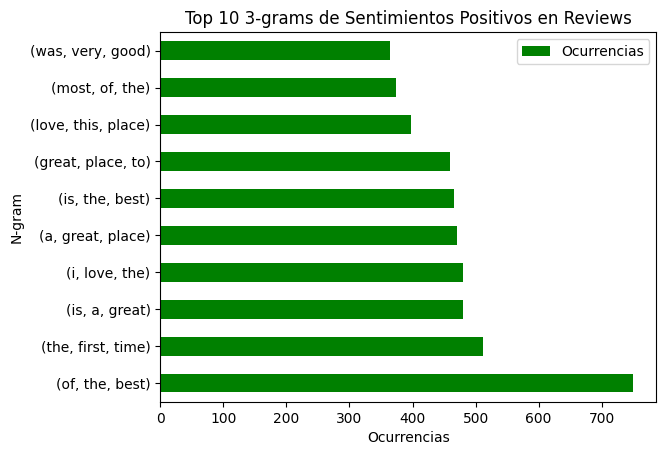

In [ ]:
plt.figure(figsize=(10, 6))
df_top_positive_ngrams.plot(kind='barh', x='N-gram', y='Ocurrencias', color='green')
plt.xlabel('Ocurrencias')
plt.ylabel('N-gram')
plt.title(f'Top 10 {n_value}-grams de Sentimientos Positivos en Reviews')
plt.show()

<Figure size 1000x600 with 0 Axes>

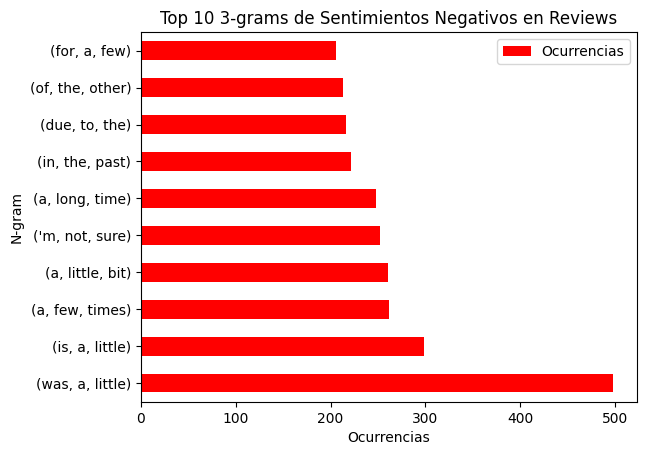

In [ ]:
plt.figure(figsize=(10, 6))
df_top_negative_ngrams.plot(kind='barh', x='N-gram', y='Ocurrencias', color='red')
plt.xlabel('Ocurrencias')
plt.ylabel('N-gram')
plt.title(f'Top 10 {n_value}-grams de Sentimientos Negativos en Reviews')
plt.show()

In [ ]:
#Con esto de alguna manera podemos analizar qué se quiere expresar en una review, basándose en la cantidad de repeticiones u ocurrencias con la cual
#se intenta conceptualizar un sentimiento. El patrón es una caracteristica que nos da una idea de algo.

**5) Keywords y Topics por Negocio**

In [ ]:
#Se puede analizar los sentimientos en base a la extracción de temas claves, es decir, 'keywords' y 'topics' a partir de los comentarios hechos en las
#reviews. Para hacer esta extracción se utiliza spaCy, donde las keywords se obtienen como lemas de las palabras en el texto que son alfabéticas y no son
#palabras de parada o stopwords, y los topics se obtienen a través de los fragmentos nominales en el texto. Se hace un conteo de ambas por negocio y se
#analiza la frecuencia de éstas.

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def extract_keywords_and_topics(text):
    doc = nlp(text)
    keywords = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    topics = [chunk.text for chunk in doc.noun_chunks]
    return keywords, topics

In [ ]:
rev['keywords'], rev['topics'] = zip(*rev['text'].apply(extract_keywords_and_topics))

In [ ]:
def count_keywords_topics(series):
    flattened_list = [item for sublist in series for item in sublist]
    return Counter(flattened_list)

In [ ]:
business_keywords_topics = rev.groupby('business_id')['keywords', 'topics'].agg(count_keywords_topics)

<ipython-input-84-42cc3ec348e7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  business_keywords_topics = rev.groupby('business_id')['keywords', 'topics'].agg(count_keywords_topics)


In [ ]:
business_keywords_topics.head()

,keywords,topics
business_id,,
--UE_y6auTgq3FXlvUMkbw,"{'come': 49, 'drama': 1, 'waitress': 39, 'nurs...","{'the drama': 1, 'the waitresses': 6, 'nurse s..."
-1t3U6osBvqFLHseoCxiIA,"{'great': 1, 'place': 1, 'work': 2, 'company':...","{'Great place': 1, 'a company': 1, 'that': 2, ..."
-6JY1T0w4XETux5kGOj84g,"{'niec': 1, 'place': 39, 'pint': 1, 'watch': 2...","{'Niec place': 1, 'a pint': 1, 'a game': 5, 'f..."
-Am2JVkb7nwvBAUwSugG0A,"{'pop': 2, 'lunch': 4, 'Saturday': 2, 'morning...","{'We': 3, 'lunch': 4, 'a Saturday morning': 1,..."
-FQL3Q-Prwxp577SFr5MfA,"{'possibly': 1, 'bad': 1, 'experience': 2, 'de...","{'the worst experience': 1, 'I': 13, 'a clothi..."


**6) Negocios con más Reviews Positivas y Negativas**

In [ ]:
#Se analiza ahora concretamente el Top 5  de negocios con más comentarios positivos y el Top 5 de los negocios con más comentarios negativos.

In [ ]:
rev['sentimiento'] = rev['text'].apply(lambda x: afinn.score(x))

In [ ]:
comentarios_positivos = rev[rev['sentimiento'] > 0]
comentarios_negativos = rev[rev['sentimiento'] < 0]

In [ ]:
top_negativos = comentarios_negativos['business_id'].value_counts().head(5)
top_positivos = comentarios_positivos['business_id'].value_counts().head(5)

In [ ]:
print("Top 5 negocios con más comentarios positivos:")
top_positivos

Top 5 negocios con más comentarios positivos:


3Q0QQPnHcJuX1DLCL9G9Cg    817
mpDxBBGywUE6GRRKja3sBA    490
NeUf9FyCCIN4MEseNyqkXQ    328
jTGQUWGIVvL-aY03C5BEmw    276
NTfUFk8GyOLL1uPbEO-pVg    241
Name: business_id, dtype: int64

In [ ]:
print("\nTop 5 negocios con más comentarios negativos:")
top_negativos


Top 5 negocios con más comentarios negativos:


3Q0QQPnHcJuX1DLCL9G9Cg    198
vKtMsWeAaThimXGo9Ic_Og     52
eThu9hCL8NOjOxswQ-cFSg     48
NeUf9FyCCIN4MEseNyqkXQ     42
wHi8ODv7TGmeUB02XoX-mA     35
Name: business_id, dtype: int64

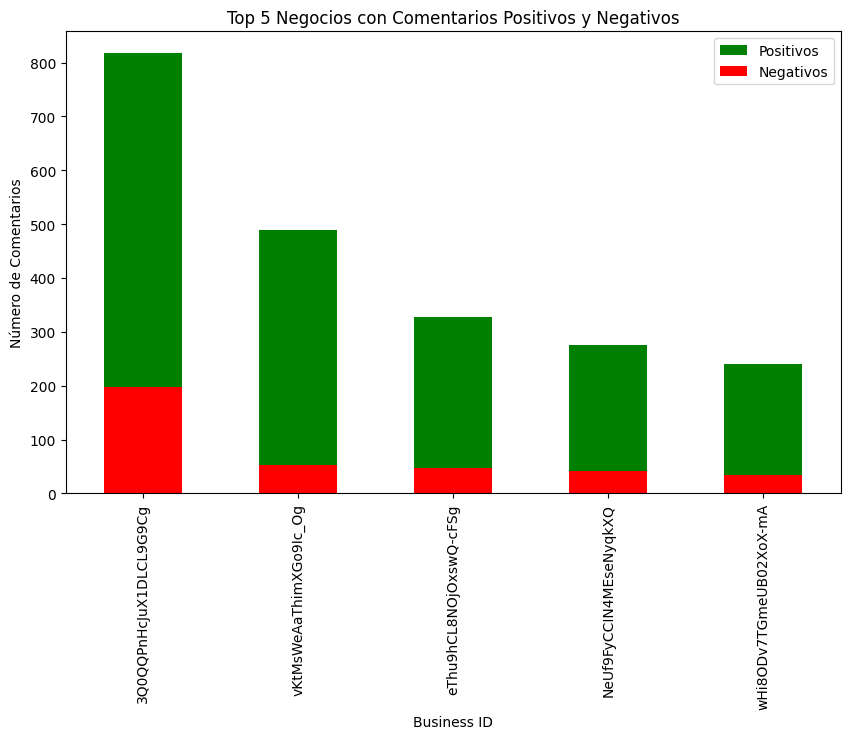

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
top_positivos.plot(kind='bar', color='green', ax=ax, label='Positivos')
top_negativos.plot(kind='bar', color='red', ax=ax, label='Negativos')

ax.set_title('Top 5 Negocios con Comentarios Positivos y Negativos')
ax.set_xlabel('Business ID')
ax.set_ylabel('Número de Comentarios')
ax.legend()

**7) Votación de Reviews**

In [ ]:
#Se nota que hay 3 columnas, 'votes.cool', 'votes.funny' y 'votes.useful'. Se quiere analizar el comportamiento de las personas, al leer una reseña.
#Cuántas personas reaccionaron votando por una review cualquiera, y cuántas no reaccionaron en absoluto por ninguna. A la vez, qué reacción predominó
#más de las 3, si para 'votes.cool', 'votes.funny' y 'votes.useful'. Y por último, qué negocio recibió más votos por sus reviews, y cuál voto predominó.

In [ ]:
rev['total_votes'] = rev['votes.cool'] + rev['votes.funny'] + rev['votes.useful']
reacciones = rev['total_votes'].apply(lambda x: 'Reaccionaron' if x > 0 else 'No reaccionaron')
conteo_reacciones = reacciones.value_counts()

In [ ]:
votos_tipo = ['votes.cool', 'votes.funny', 'votes.useful']
predominante = rev[votos_tipo].idxmax(axis=1)
conteo_predominante = predominante.value_counts()

In [ ]:
negocio_mas_votos = rev.groupby('business_id')['total_votes'].sum().idxmax()
voto_predominante_negocio = rev[rev['business_id'] == negocio_mas_votos][votos_tipo].idxmax(axis=1).value_counts().idxmax()

In [ ]:
print("Cantidad de personas que reaccionaron y no reaccionaron:")
conteo_reacciones

Cantidad de personas que reaccionaron y no reaccionaron:


No reaccionaron    14517
Reaccionaron       12773
Name: total_votes, dtype: int64

In [ ]:
print("\nReacción predominante entre 'votes.cool', 'votes.funny' y 'votes.useful':")
conteo_predominante


Reacción predominante entre 'votes.cool', 'votes.funny' y 'votes.useful':


votes.cool      17956
votes.useful     7681
votes.funny      1653
dtype: int64

In [ ]:
print("Negocio con más votos:", negocio_mas_votos)
print("Voto predominante en ese negocio:", voto_predominante_negocio)

Negocio con más votos: 3Q0QQPnHcJuX1DLCL9G9Cg
Voto predominante en ese negocio: votes.cool


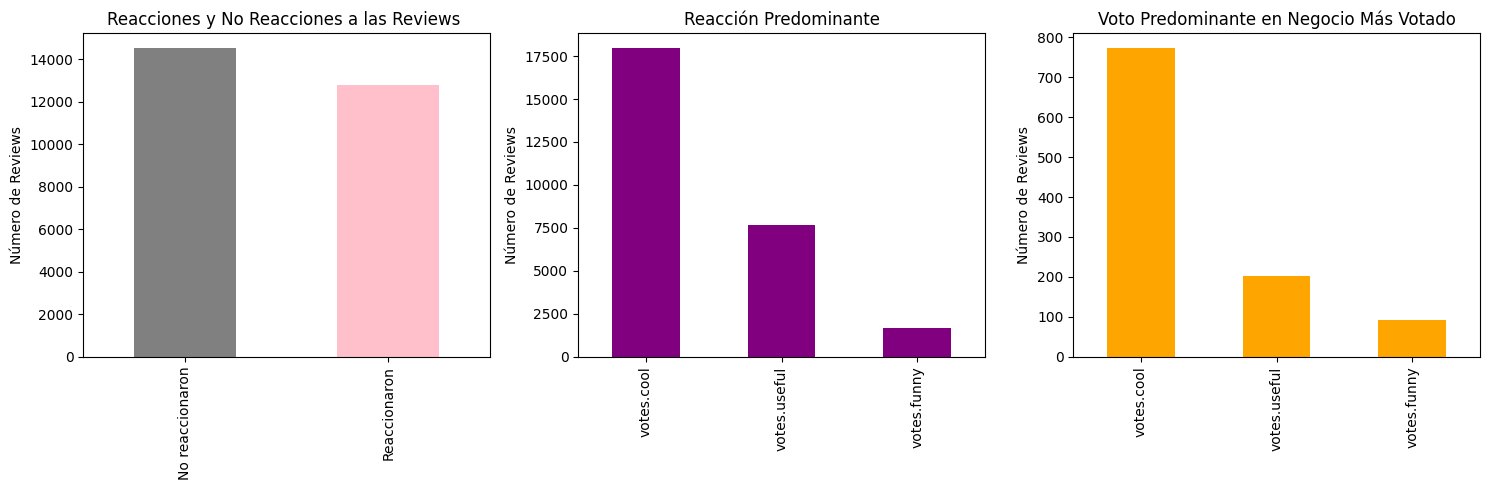

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

conteo_reacciones.plot(kind='bar', ax=axes[0], color=['gray', 'pink'])
axes[0].set_title('Reacciones y No Reacciones a las Reviews ')
axes[0].set_ylabel('Número de Reviews')

conteo_predominante.plot(kind='bar', ax=axes[1], color='purple')
axes[1].set_title('Reacción Predominante')
axes[1].set_ylabel('Número de Reviews')

rev[rev['business_id'] == negocio_mas_votos][votos_tipo].idxmax(axis=1).value_counts().plot(kind='bar', ax=axes[2], color='orange')
axes[2].set_title('Voto Predominante en Negocio Más Votado')
axes[2].set_ylabel('Número de Reviews')

plt.tight_layout()
plt.show()

In [ ]:
#Se quiere saber cuál fue el negocio más votado y cuántos recibió en total.

In [ ]:
rev['total_votes'] = rev['votes.cool'] + rev['votes.funny'] + rev['votes.useful']

In [ ]:
votos_por_negocio = rev.groupby('business_id')['total_votes'].sum()

In [ ]:
negocio_mas_votado = votos_por_negocio.idxmax()
votos_negocio_mas_votado = votos_por_negocio.max()

In [ ]:
print("Negocio más votado:")
print("ID del Negocio:", negocio_mas_votado)
print("Total de Votos:", votos_negocio_mas_votado)

Negocio más votado:
ID del Negocio: 3Q0QQPnHcJuX1DLCL9G9Cg
Total de Votos: 2041


**8) Coherencia entre Rating y Sentimiento Expresado**

In [ ]:
#Se quiere analizar si el nivel de rating 'stars' puestas por el que reseñó, tiene coherencia con el sentimiento que expresa en el texto 'text' de la
#reseña. Como esta aproximación es subjetiva, se opta por usar TextBlob como opción para realizar análisis de subjetividad en texto.

In [ ]:
rev['subjectivity'] = rev['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

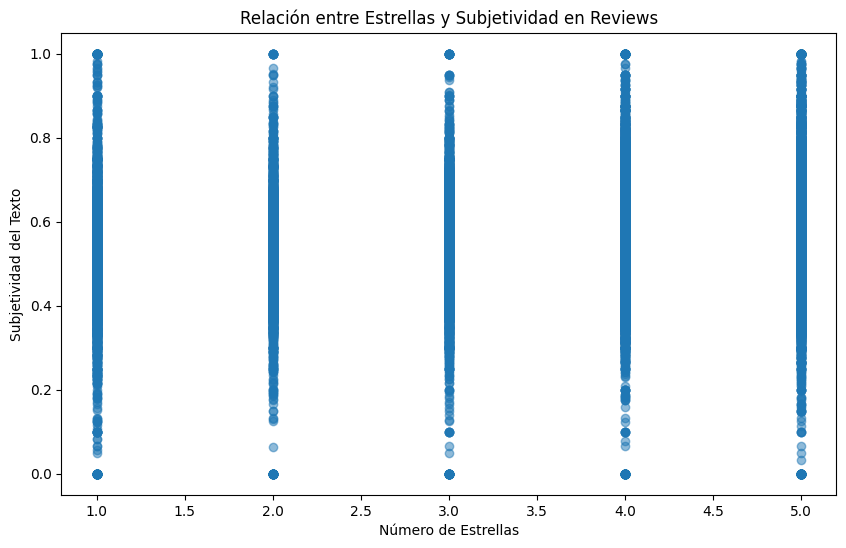

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(rev['stars'], rev['subjectivity'], alpha=0.5)
plt.title('Relación entre Estrellas y Subjetividad en Reviews')
plt.xlabel('Número de Estrellas')
plt.ylabel('Subjetividad del Texto')
plt.show()

In [ ]:
#Se crea un gráfico de dispersión que muestra la relación entre el número de rating asignado y la subjetividad del texto. Un patrón coherente podría
#indicar que los usuarios tienden a dar estrellas más altas a reviews más subjetivas, o viceversa. Las posibles aproximaciones y las interpretaciones de
#la subjetividad es subjetiva en sí misma.

In [ ]:
#Hay algunas consideraciones para analizar un gráfico de dispersión en este contexto, por ejemplo, tendencias generales donde se examine la distribución
#general de los puntos en el gráfico. Otro caso es analizar la correlación, calculando el coeficiente de correlación para medir la fuerza y la dirección
#de la relación lineal entre las dos variables. Un coeficiente de correlación cercano a 1 indica una fuerte correlación positiva, mientras que un valor
#cercano a -1 indica una fuerte correlación inversa. Un valor cercano a 0 sugiere una correlación débil o inexistente. Y por último se puede analizar la
#densidad de puntos, las áreas más oscuras indicarán una mayor densidad de puntos, mientras que las áreas más claras indicarán una menor densidad.

In [ ]:
correlation_coefficient = rev['stars'].corr(rev['subjectivity'])

In [ ]:
print("Coeficiente de correlación entre 'stars' y 'subjectivity':", correlation_coefficient)

Coeficiente de correlación entre 'stars' y 'subjectivity': 0.14730291546164304


In [ ]:
#Se puede ver que la relación es prácticamente débil entre el sentimiento que expresa el texto de la review y la cantidad de puntuación en estrellas.

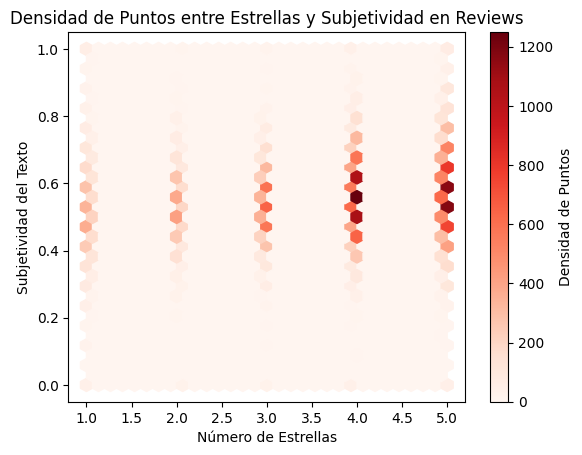

In [ ]:
plt.hexbin(rev['stars'], rev['subjectivity'], gridsize=30, cmap='Reds')
plt.title('Densidad de Puntos entre Estrellas y Subjetividad en Reviews')
plt.xlabel('Número de Estrellas')
plt.ylabel('Subjetividad del Texto')
plt.colorbar(label='Densidad de Puntos')
plt.show()

In [ ]:
#Por otro lado, en el contexto de análisis de sentimientos, la subjetividad del texto es una medida que indica en qué medida el texto es subjetivo u
#objetivo. Esta medida generalmente se encuentra en un rango de 0 a 1 como se aprecia en el gráfico.

In [ ]:
#0: Indica que el texto es completamente objetivo. En otras palabras, el texto es puramente informativo y no contiene opiniones personales, emociones
#u evaluaciones subjetivas. El 1: Indica que el texto es completamente subjetivo. En este extremo del espectro, el texto está altamente influenciado
#por opiniones personales, emociones y evaluaciones subjetivas. Mientras que un valor de subjetividad entre 0 y 1 significa que el texto tiene un grado
#variable de subjetividad. Por ejemplo: Un valor cercano a 0.2 podría indicar un texto que tiende a ser más objetivo que subjetivo. Un valor cercano a
#0.8 podría indicar un texto que tiende a ser más subjetivo que objetivo.

In [ ]:
#Si la subjetividad está concentrada en un rango específico (lo que se ve está entre 0.4 y 0.6), podría sugerir que las reviews en ese rango tienden a ser
#moderadamente subjetivas y contienen una mezcla de información objetiva y opiniones personales.

In [ ]:
X = rev['stars'].values.reshape(-1, 1)
y = rev['subjectivity'].values
model = LinearRegression().fit(X, y)
regression_line = model.predict(X)

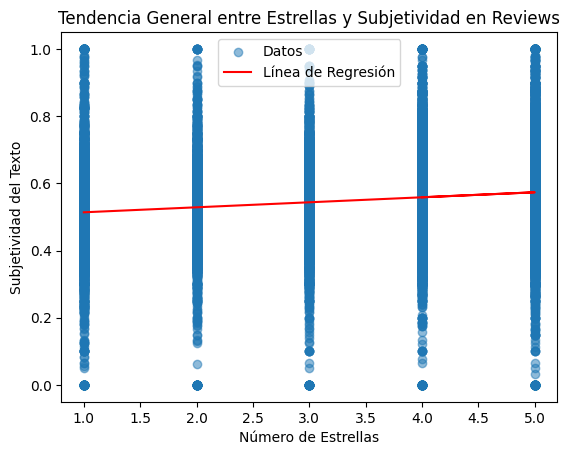

In [ ]:
plt.scatter(rev['stars'], rev['subjectivity'], alpha=0.5, label='Datos')
plt.plot(rev['stars'], regression_line, color='red', label='Línea de Regresión')
plt.title('Tendencia General entre Estrellas y Subjetividad en Reviews')
plt.xlabel('Número de Estrellas')
plt.ylabel('Subjetividad del Texto')
plt.legend()
plt.show()

In [ ]:
#Las tendencias generales en un gráfico de dispersión, se ajusta con una línea de regresión lineal para visualizar la dirección y la fuerza de la
#relación entre las variables. Una pendiente positiva indica una relación positiva, como se ve en este caso.

In [ ]:
#Esto significa que, en promedio, a medida que el número de estrellas aumenta, también tiende a aumentar la subjetividad del texto.

In [ ]:
#Sin embargo, el coeficiente de correlación es relativamente bajo (0.147), lo que sugiere que la relación no es fuerte.

In [ ]:
#La aparente discrepancia entre la pendiente positiva y el coeficiente de correlación bajo puede deberse a la presencia de puntos atípicos o a la
#naturaleza no lineal de la relación. La regresión lineal asume una relación lineal, pero si la relación es más compleja, un coeficiente de correlación
#bajo puede indicar que la relación no es bien capturada por una línea recta.

In [ ]:
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(rev[['stars']], rev['subjectivity'])
regression_line = model.predict(rev[['stars']])

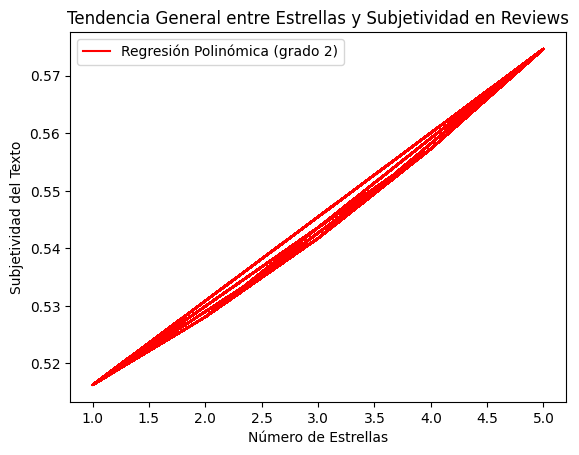

In [ ]:
plt.plot(rev['stars'], regression_line, color='red', label=f'Regresión Polinómica (grado {degree})')
plt.title('Tendencia General entre Estrellas y Subjetividad en Reviews')
plt.xlabel('Número de Estrellas')
plt.ylabel('Subjetividad del Texto')
plt.legend()
plt.show()

In [ ]:
#Se aprecia entonces ahora si, que aquellos que:

#Reviews de 1 Estrella:
#Subjetividad: Baja a moderada (0 a 0.52).
#Interpretación: Tienden a ser más objetivas y determinantes en su expresión negativa, con una baja a moderada subjetividad.

#Reviews de 2 a 4 Estrellas:
#Subjetividad: Moderada (0.50 a 0.57).
#Interpretación: Tienden a ser moderadamente subjetivas tanto en la expresión como en la puntuación. Los que reseñan en este rango pueden tener opiniones
#más equilibradas y expresar subjetividad moderada.

#Reviews de 5 Estrellas:
#Subjetividad: Alta (0.57 a 1).
#Interpretación: Se muestra una alta subjetividad en tanto en la expresión como en la puntuación. Aquí expresan sus opiniones fuertemente subjetivas y
#cargadas de sentimiento positivo.

In [ ]:
#Cuando más subjetiva es la review, más incoherente puede ser lo que se siente y se expresa, con el rating de estrellas que se opta por calificar.

In [ ]:
#Eso explica, porque la correlación por 'business_id' da en un ejemplo, 0,17 otorgando 4 estrellas, o 0,25 otorgando 5 estrellas, mientras que en otro caso
#para 0,95 otorga la misma cantidad de estrellas.

**9) Fecha con mayor Registro de Reviews**

In [ ]:
#En qué fecha se registraron más reviews? Esta pregunta que se hace es con el propósito de determinar en qué momento del año y en qué año hubo más
#concurrencia, por la cual luego de la experiencia, fue alta la voluntad de dejar una review al respecto.

In [ ]:
rev['date'] = pd.to_datetime(rev['date'])

In [ ]:
reseñas_por_fecha = rev.groupby('date').size().reset_index(name='count')

In [ ]:
fecha_max_reseñas = reseñas_por_fecha.loc[reseñas_por_fecha['count'].idxmax()]

In [ ]:
print("Fecha con el máximo número de reviews:")
fecha_max_reseñas

Fecha con el máximo número de reviews:


date     2015-08-10 00:00:00
count                     35
Name: 2890, dtype: object

In [ ]:
#Para analizar si hubo más sentimientos positivos o negativos en la fecha con el máximo número de reviews, así como la cantidad de votos al respecto,
#se puede ver la distribución de estrellas o rating, y sumar los votos (votes.cool, votes.funny, votes.useful) para obtener el total de votos recibidos.

In [ ]:
fecha_max_reseñas = rev['date'].value_counts().idxmax()

In [ ]:
reseñas_en_fecha_max = rev[rev['date'] == fecha_max_reseñas]

In [ ]:
distribucion_estrellas = reseñas_en_fecha_max['stars'].value_counts()

In [ ]:
total_votos = reseñas_en_fecha_max[['votes.cool', 'votes.funny', 'votes.useful']].sum().sum()

In [ ]:
tipo_de_voto_mas_frecuente = reseñas_en_fecha_max[['votes.cool', 'votes.funny', 'votes.useful']].sum().idxmax()

In [ ]:
print("Distribución de Estrellas en la Fecha con Más Reviews:")
print(distribucion_estrellas)
print("\nTotal de Votos en la Fecha con Más Reviews:", total_votos)
print("Tipo de Voto Más Frecuente en la Fecha con Más Reviews:", tipo_de_voto_mas_frecuente)

Distribución de Estrellas en la Fecha con Más Reviews:
5    13
2     7
4     7
1     5
3     3
Name: stars, dtype: int64

Total de Votos en la Fecha con Más Reviews: 33
Tipo de Voto Más Frecuente en la Fecha con Más Reviews: votes.useful


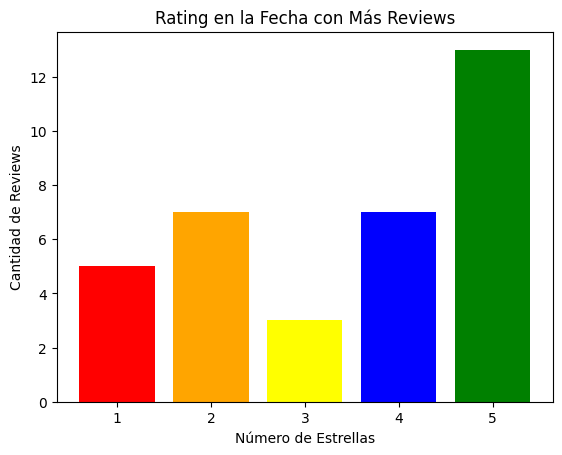

In [ ]:
plt.bar(distribucion_estrellas.index, distribucion_estrellas.values, color=['green', 'orange', 'blue', 'red', 'yellow'])
plt.title('Rating en la Fecha con Más Reviews')
plt.xlabel('Número de Estrellas')
plt.ylabel('Cantidad de Reviews')
plt.show()

In [ ]:
#Si se quisiera analizar los sentimientos positivos o negativos, pero en vez de analizar la distribución de estrellas, fuera por las palabras que resaltan
#positividad o negatividad predominantemente, se puede utilizar TextBlob para asignar un valor de polaridad de sentimiento a cada reseña.

In [ ]:
fecha_max_reseñas = rev['date'].value_counts().idxmax()

In [ ]:
reseñas_en_fecha_max = rev[rev['date'] == fecha_max_reseñas]

In [ ]:
pd.set_option('mode.chained_assignment', None)
reseñas_en_fecha_max['sentimiento'] = reseñas_en_fecha_max['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [ ]:
distribucion_sentimientos = pd.cut(reseñas_en_fecha_max['sentimiento'], bins=[-1, 0, 1], labels=['Negativo', 'Positivo']).value_counts()

In [ ]:
print("Distribución de Sentimientos en la Fecha con Más Reviews:")
distribucion_sentimientos

Distribución de Sentimientos en la Fecha con Más Reviews:


Positivo    31
Negativo     4
Name: sentimiento, dtype: int64

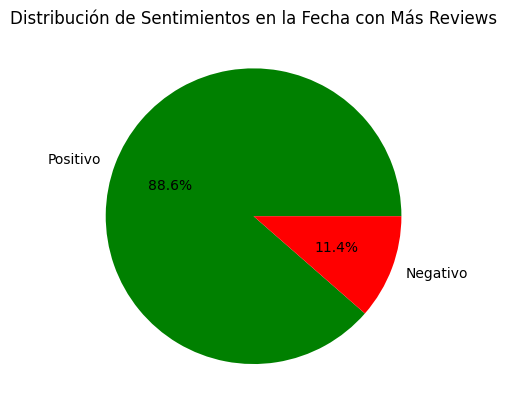

In [ ]:
plt.pie(distribucion_sentimientos, labels=distribucion_sentimientos.index, autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Distribución de Sentimientos en la Fecha con Más Reviews')
plt.show()

**10) Sentimientos a lo Largo del Tiempo**

In [ ]:
#Ahora analizando toda la columna 'date', no de una fecha concreta, sino de todas las reviews que hay, se quiere analizar los sentimientos a lo largo
#del tiempo.

In [ ]:
sentimiento_promedio_por_fecha = rev.groupby('date')['sentimiento'].mean()

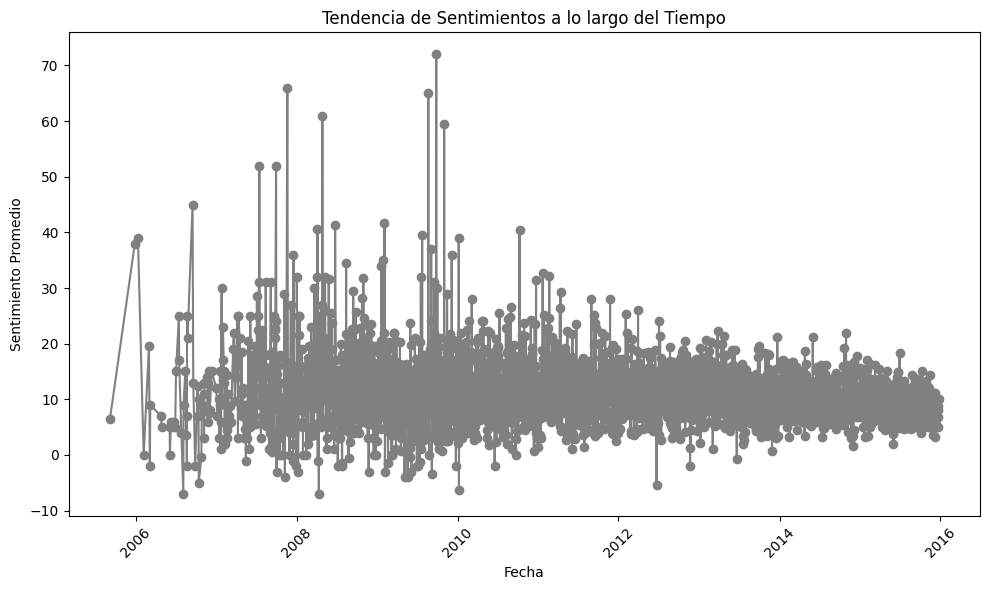

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sentimiento_promedio_por_fecha.index, sentimiento_promedio_por_fecha.values, marker='o', linestyle='-', color='grey')
plt.title('Tendencia de Sentimientos a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Sentimiento Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Cuando se observa una tendencia donde la mayoría de los puntos están concentrados en un rango más estrecho, como entre 0 y 20, mientras que hay algunos
#puntos dispersos en un rango más amplio (por ejemplo, de -10 a 70), puede indicar varias cosas sobre las reviews y sus sentimientos a lo largo del tiempo.
#Entre esas, está el 'Análisis de Temas y Opiniones', esto puede ayudar a identificar temas recurrentes y áreas específicas de preocupación o satisfacción.

In [ ]:
#Se utiliza un modelo de análisis de sentimiento de Hugging Face para asignar un sentimiento (positivo o negativo) a cada review.

In [ ]:
nlp = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
max_sequence_length = 512

In [ ]:
rev['text'] = rev['text'].apply(lambda x: x[:max_sequence_length])

In [ ]:
rev['sentiment'] = rev['text'].apply(lambda x: nlp(x)[0]['label'])

In [ ]:
sentiment_distribution = rev['sentiment'].value_counts()

In [ ]:
sentiment_distribution

POSITIVE    18627
NEGATIVE     8663
Name: sentiment, dtype: int64

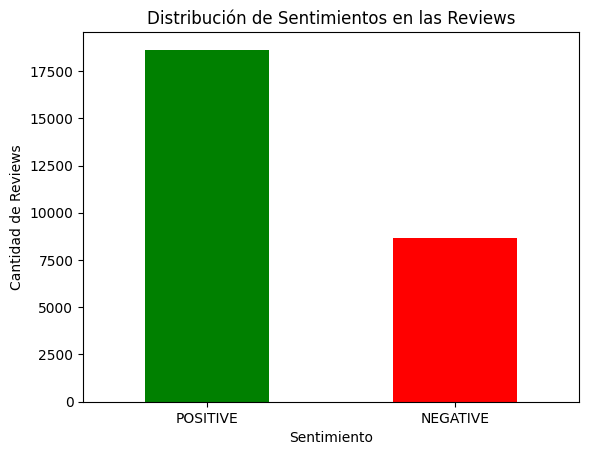

In [ ]:
sentiment_distribution.plot(kind='bar', rot=0, color=['green', 'red'])
plt.title('Distribución de Sentimientos en las Reviews')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Reviews')
plt.show()

In [ ]:
#Si se quisiera agregar una clasificación adicional al sentimiento, por ejemplo, neutral, se puede establecer un umbral, por ejemplo, si la diferencia entre
#las probabilidades de un sentimiento positivo y negativo es pequeña.

In [ ]:
def get_sentiment_label(probabilities, neutral_threshold=0.1):
    positive_prob = probabilities['score'] if probabilities['label'] == 'POSITIVE' else 1 - probabilities['score']
    negative_prob = probabilities['score'] if probabilities['label'] == 'NEGATIVE' else 1 - probabilities['score']

    if abs(positive_prob - negative_prob) < neutral_threshold:
        return 'NEUTRAL'
    else:
        return probabilities['label']

In [ ]:
rev['text'] = rev['text'].apply(lambda x: x[:max_sequence_length])

In [ ]:
sentiment_probabilities = nlp(list(rev['text'].values.tolist()))

In [ ]:
rev['sentiment'] = [get_sentiment_label(prob) for prob in sentiment_probabilities]

In [ ]:
sentiment_distribution = rev['sentiment'].value_counts()

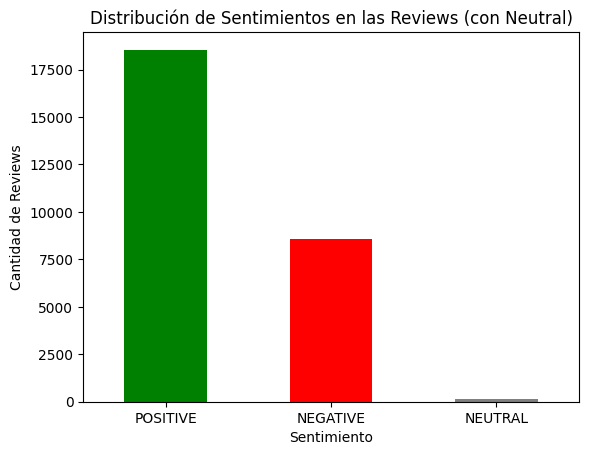

In [ ]:
sentiment_distribution.plot(kind='bar', rot=0, color=['green', 'red', 'gray'])
plt.title('Distribución de Sentimientos en las Reviews (con Neutral)')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Reviews')
plt.show()

**SECCIÓN 4** - CONCLUSIÓN

En esta entrega hubo desafíos técnicos en la exploración y manipulación de datos, dado que muchas de las líneas de código requerían un tiempo considerable de ejecución a la vez de que era alta la demanda de recursos del procesador.
Resumiento, se encontró que no existe una correlación fuerte entre lo que se expresa en una review y el rating que se le asigna, y que el sentimiento inducido es ampliamente visible de ser positivo o negativo, siendo prácticamente despreciable la brecha entre ambos oscilando en la apreciación de tomarlo como neutral. Por otro lado, los votos que se dieron por estar de acuerdo con una review puntualmente, si bien define una interacción con el usuario que escribe y no con el negocio puntualmente, de igual forma marca una tendencia que enaltese aún más la apreciación de este, dado que hay factores tales como personalidad y tipo de relación que impactan en el contagio emocional de lo que se lee. Aún así, hay más lectores que no reaccionan a las reviews, de los que si lo hacen, por lo que se podría decir que no se evidencia una influencia totalmente. Muchos de estos parámetros podrían ser analizados en base a otros enfoques para estudiar el comportamiento del usuario, tanto sea de manera directa como indirecta en al momento de expresar su experiencia acerca de la satisfacción, conformidad o no, con cualquier foco que esté sometido a la opinión.




In [ ]:
#FIN.